In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import os
import numpy as np
import pandas as pd
from glob import glob
import statsmodels.api as sm
from typing import List
import itertools
import matplotlib.pyplot as plt
from scipy import stats
import calpgs
from sklearn.model_selection import train_test_split
import seaborn as sns
from plot_utils import group_boxplot, lighten_boxplot
from tqdm import tqdm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

np.random.seed(42)
plt.rcParams["font.family"] = "Arial"

# Overview
We have genetic component $g$, environment component $e$, two covariates (one continuous, mimicking age, and one binary, mimicking sex) $c_1, c_2$ and their corresponding effects $\alpha_1, \alpha_2$. The phenotype is defined as $y = g + e + c_1 \alpha_1 + c_2 \alpha_2$. 

We assume that some PRS is derived $\hat{g}$, and it is assumed that $E[\hat{g} - g] = 0$. But for some reason, $\hat{g} \sim \mathcal{N}(g, \tau_0 + \tau_1 c_1 + \tau_2 c_2)$. Therefore, some differntial performance between $\hat{g}$ and $g$ across groups of individuals.


In [2]:
df_cov = pd.read_csv("data/cov.tsv", sep="\t", index_col=0).reset_index(drop=True)
n_indiv = df_cov.shape[0]
df_cov["GIA"] = np.sort(stats.expon.ppf(np.linspace(0.01, 0.4, n_indiv)))[
    stats.rankdata(df_cov["PC1"], method="ordinal") - 1
]
df_cov.drop(columns="PC1", inplace=True)

df_cov = (df_cov - df_cov.mean(axis=0)) / df_cov.std(axis=0)

In [3]:
def simulate_data(
    df_cov: pd.DataFrame,
    cov_effects: np.ndarray,
    baseline_r2: float,
    n_train=5000,
    n_test=5000,
    n_dummy=50,
):
    """
    Simulate phenotype, PRS, with the noise level as a function of covariates

    Parameters
    ----------
    n_indiv: int
        number of individuals
    baseline_r2: float
        R2 of PRS
    cov: np.ndarray
        covariates matrix
    cov_effects: np.ndarray
        1d vector covariate effects
    """
    # sub-sample covariates
    df_cov = df_cov.sample(n=n_train + n_test)
    cov = df_cov.values
    n_indiv = cov.shape[0]
    if not isinstance(cov_effects, np.ndarray):
        cov_effects = np.array(cov_effects)
    assert cov.shape[0] == n_indiv
    assert cov.shape[1] == len(cov_effects)
    pred = np.random.normal(size=n_indiv)

    design = np.hstack([np.ones((n_indiv, 1)), pred.reshape(-1, 1), cov])

    true_beta = np.array([0, 1] + [0] * cov.shape[1])
    true_gamma = np.array([np.log(1 / baseline_r2 - 1), 0] + list(cov_effects))
    y = np.random.normal(
        loc=design @ true_beta, scale=np.sqrt(np.exp(design @ true_gamma))
    )

    df_trait = pd.concat(
        [
            pd.DataFrame({"pred": pred, "y": y}, index=df_cov.index),
            df_cov,
        ],
        axis=1,
    )
    df_trait["predstd0"] = 1.0
    for col in ["AGE", "GIA", "SEX"]:
        n_unique = len(np.unique(df_trait[col]))
        if n_unique > 5:
            col_q = pd.qcut(df_trait[col], q=5).cat.codes
        else:
            col_q = pd.Categorical(df_trait[col]).codes
        df_trait[f"{col}_q"] = col_q

    # add dummy variable
    for i in range(n_dummy):
        df_trait[f"DUMMY{i}"] = np.random.normal(size=len(df_trait))
    df_train, df_test = train_test_split(df_trait, test_size=n_test, train_size=n_train)
    return df_train, df_test

In [4]:
# effects for age, sex, GIA
cov_effects = [0.25, 0.2, 0.15]
dict_data = {}
for n_calibrate in [100, 500, 2500, 5000]:
    for seed in range(50):
        np.random.seed(seed)
        df_train, df_test = simulate_data(
            df_cov=df_cov,
            cov_effects=cov_effects,
            baseline_r2=0.3,
            n_train=n_calibrate,
            n_test=5000,
        )
        dict_data[(n_calibrate, seed)] = df_train, df_test

# Compute experiment raw data

In [13]:
def evaluate_metrics(df_cal, df_test, adjust_cols):
    """
    Given a dataframe to perform calibration and testing, and columns to adjust
    report (1) coverage (2) R2

    # by default, adjust_cols = ["AGE", "SEX", "GIA"]
    """

    if adjust_cols is None:
        adjust_cols = []
    df_cal, df_test = df_cal.copy(), df_test.copy()

    dict_coverage = {}
    dict_r2 = {}

    train_y = df_cal["y"]
    train_x = sm.add_constant(df_cal[["pred"]])
    train_z = sm.add_constant(df_cal[adjust_cols])

    test_x = sm.add_constant(df_test[["pred"]])
    test_z = sm.add_constant(df_test[adjust_cols])

    # adjust
    res = calpgs.calibrate_and_adjust(
        train_x=train_x.values,
        train_z=train_z.values,
        train_y=train_y.values,
        test_x=test_x.values,
        test_z=test_z.values,
    )
    df_test["cal_pred"], df_test["cal_predstd"] = res[0:2]

    # evaluate
    for group_col in [None, "AGE_q", "GIA_q", "SEX_q"]:
        df_summary = calpgs.summarize_pred(
            df_test,
            y_col="y",
            pred_col="pred",
            predstd_col="cal_predstd",
            group_col=group_col,
        )
        if group_col is None:
            dict_coverage["marginal"] = df_summary["coverage"]
            dict_r2["marginal"] = df_summary["r2"]
        else:
            for i in df_summary.index:
                dict_coverage[f"{group_col}_{i}"] = df_summary["coverage"][i]
                dict_r2[f"{group_col}_{i}"] = df_summary["r2"][i]

    return pd.Series(dict_coverage), pd.Series(dict_r2)

In [14]:
dict_df_plot = dict()

for adjust in ["all", "none", "dummy5", "dummy25"]:
    if adjust == "all":
        adjust_cols = ["AGE", "SEX", "GIA"]
    elif adjust == "except-age":
        adjust_cols = ["SEX", "GIA"]
    elif adjust.startswith("dummy"):
        n_dummy = int(adjust.lstrip("dummy"))
        adjust_cols = ["AGE", "SEX", "GIA"] + [f"DUMMY{i}" for i in range(n_dummy)]
    elif adjust == "none":
        adjust_cols = None
    else:
        raise NotImplementedError
    dict_df_coverage = dict()
    dict_df_r2 = dict()

    for n_calibrate in tqdm([100, 500, 2500, 5000]):
        df_coverage = []
        df_r2 = []
        for seed in range(50):
            df_train, df_test = dict_data[(n_calibrate, seed)]
            tmp_cov, tmp_r2 = evaluate_metrics(
                df_train, df_test, adjust_cols=adjust_cols
            )
            df_coverage.append(tmp_cov)
            df_r2.append(tmp_r2)
        dict_df_coverage[n_calibrate] = pd.concat(df_coverage, axis=1).T
        dict_df_r2[n_calibrate] = pd.concat(df_r2, axis=1).T

    df_plot = {"n": [], "col": [], "coverage": [], "r2": []}

    for n in dict_df_coverage:
        for col in dict_df_coverage[n].columns:
            covs = dict_df_coverage[n][col].values
            df_plot["n"].extend([n] * len(covs))
            df_plot["col"].extend([col] * len(covs))
            df_plot["coverage"].extend(covs)
            df_plot["r2"].extend(dict_df_r2[n][col])

    df_plot = pd.DataFrame(df_plot)
    dict_df_plot[adjust] = df_plot

  0%|          | 0/4 [00:00<?, ?it/s]

n=100, beta=[-0.06720961  0.95887049], gamma=[0.85685214 0.50742751 0.14509841 0.38866735]
n=100, beta=[-0.2565649   1.07216861], gamma=[0.71035038 0.10457234 0.52982129 0.32494895]
n=100, beta=[0.16559664 1.23721866], gamma=[ 0.67466112  0.0226999   0.16519213 -0.1127545 ]
n=100, beta=[0.07943752 0.97886138], gamma=[ 0.73109931  0.35135985 -0.02938181  0.26479668]
n=100, beta=[0.20321754 0.98568074], gamma=[0.72888471 0.36485083 0.06089139 0.11443797]
n=100, beta=[0.12487738 0.8918086 ], gamma=[0.82445051 0.41601045 0.16236335 0.29119684]
n=100, beta=[0.03867998 0.73577209], gamma=[0.73933243 0.17841857 0.06410996 0.13030631]
n=100, beta=[-0.09661573  0.99751146], gamma=[1.01434497 0.44414243 0.25326171 0.06155719]
n=100, beta=[-0.10027405  1.05034504], gamma=[0.62423136 0.25669067 0.31884833 0.07406205]
n=100, beta=[-0.05519544  1.18052055], gamma=[ 0.86527601  0.16374486  0.07639151 -0.00585264]
n=100, beta=[0.03971297 1.3317017 ], gamma=[ 0.81954351 -0.00176277  0.2385889   0.17923

 25%|██▌       | 1/4 [00:02<00:07,  2.35s/it]

n=100, beta=[0.14551385 0.83628797], gamma=[1.2096692  0.08492098 0.35126527 0.16153845]
n=100, beta=[0.27814813 0.93587456], gamma=[ 0.79027117 -0.17363677  0.32570233 -0.28828662]
n=500, beta=[0.08225328 0.90065862], gamma=[0.70779897 0.23851304 0.14155563 0.28820841]
n=500, beta=[0.05052432 0.97525935], gamma=[0.86849011 0.31663708 0.18557861 0.16526062]
n=500, beta=[-0.15887117  1.01639757], gamma=[0.79417201 0.29238124 0.29699303 0.14191431]
n=500, beta=[-0.09117148  0.96243883], gamma=[0.86950499 0.25995565 0.21748655 0.19922343]
n=500, beta=[0.05221642 1.05765621], gamma=[0.87257661 0.19156305 0.23278845 0.12901622]
n=500, beta=[-0.13968341  0.98451183], gamma=[0.81878866 0.28988999 0.14559073 0.15700832]
n=500, beta=[-0.089815    0.92336363], gamma=[0.79925191 0.28354873 0.37559351 0.06985446]
n=500, beta=[0.05599788 1.07713344], gamma=[0.80314879 0.39566943 0.26839995 0.08818186]
n=500, beta=[5.06975521e-04 8.92312048e-01], gamma=[ 0.93697455  0.22426166  0.26274845 -0.0105920

 50%|█████     | 2/4 [00:04<00:04,  2.45s/it]

n=500, beta=[-0.04413641  0.99426914], gamma=[0.84368099 0.2169453  0.16901052 0.16230735]
n=2500, beta=[-2.28138158e-04  9.76805791e-01], gamma=[0.86634271 0.21142682 0.21004286 0.16528201]
n=2500, beta=[-0.03815538  0.96589452], gamma=[0.83174587 0.22836832 0.13820748 0.09484959]
n=2500, beta=[-0.00401147  0.97405342], gamma=[0.85809271 0.25518348 0.1782003  0.14553656]
n=2500, beta=[5.66404114e-04 1.00673656e+00], gamma=[0.83488655 0.27621387 0.25311707 0.18563072]
n=2500, beta=[0.05428751 1.01474735], gamma=[0.83313998 0.27132821 0.24626333 0.15780726]
n=2500, beta=[0.02337247 1.01371804], gamma=[0.86245361 0.25823318 0.24220818 0.17778702]
n=2500, beta=[-0.02607664  0.96196692], gamma=[0.85761269 0.24999311 0.18543077 0.13211644]
n=2500, beta=[-0.00966639  1.05245693], gamma=[0.83787375 0.30249982 0.18946375 0.16079326]
n=2500, beta=[-0.0063834   0.99631011], gamma=[0.82599531 0.23853217 0.17868647 0.1427979 ]
n=2500, beta=[-0.01230286  1.00412086], gamma=[0.89929945 0.28066327 0.

 75%|███████▌  | 3/4 [00:07<00:02,  2.42s/it]

n=2500, beta=[0.07468988 0.95661437], gamma=[0.81273807 0.22568852 0.17771933 0.15951338]
n=2500, beta=[6.19300786e-04 9.89863786e-01], gamma=[0.88842838 0.24412953 0.19650205 0.15819548]
n=2500, beta=[-0.04457569  0.96203669], gamma=[0.86788219 0.27674831 0.19741404 0.19836602]
n=5000, beta=[-0.01076078  1.00760662], gamma=[0.82427489 0.20341897 0.18886827 0.12236259]
n=5000, beta=[0.00721152 0.97506057], gamma=[0.87986792 0.23901198 0.21484707 0.11591975]
n=5000, beta=[-6.83805611e-04  1.02185023e+00], gamma=[0.84273696 0.25058514 0.21432884 0.12315669]
n=5000, beta=[0.06636969 1.0223946 ], gamma=[0.87030526 0.24287202 0.20913647 0.13837978]
n=5000, beta=[-0.0082656   1.00039108], gamma=[0.84653119 0.26022198 0.17154144 0.17828813]
n=5000, beta=[0.01330351 1.00938927], gamma=[0.85162672 0.23706643 0.20791113 0.17967736]
n=5000, beta=[-0.02681003  1.02586549], gamma=[0.85379621 0.27045051 0.22856865 0.17903361]
n=5000, beta=[0.00542948 0.99905749], gamma=[0.82345786 0.22914678 0.22970

100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


n=5000, beta=[0.02588366 1.01440269], gamma=[0.86416386 0.25129652 0.16871387 0.15050744]
n=5000, beta=[0.01420634 0.97985187], gamma=[0.85645931 0.20684501 0.20794554 0.11521291]


  0%|          | 0/4 [00:00<?, ?it/s]

n=100, beta=[0.01090098 0.88193717], gamma=[1.00701414]
n=100, beta=[-0.10302249  1.1371864 ], gamma=[0.93304607]
n=100, beta=[0.15386812 1.19944533], gamma=[0.66968649]
n=100, beta=[0.0566741  0.97357736], gamma=[0.72565854]
n=100, beta=[0.28303956 0.95453368], gamma=[0.80376973]
n=100, beta=[0.18637515 0.95808471], gamma=[0.91333416]
n=100, beta=[0.03826692 0.73940187], gamma=[0.78071021]
n=100, beta=[-0.12860425  0.93825457], gamma=[1.21014436]
n=100, beta=[-0.04980901  1.07407591], gamma=[0.72298211]
n=100, beta=[-0.06505983  1.16901342], gamma=[0.89800396]
n=100, beta=[0.03750083 1.3242598 ], gamma=[0.83283784]
n=100, beta=[-0.01694176  0.9104654 ], gamma=[0.70952792]
n=100, beta=[-0.02379018  0.89128587], gamma=[0.62301634]
n=100, beta=[0.12289189 0.88449085], gamma=[0.76544403]
n=100, beta=[-0.22352918  1.10531689], gamma=[0.70735341]
n=100, beta=[0.0077637  0.81951071], gamma=[0.53275502]
n=100, beta=[-0.19385884  1.35144998], gamma=[0.75908634]
n=100, beta=[0.27220215 1.094537

 25%|██▌       | 1/4 [00:02<00:06,  2.12s/it]

n=100, beta=[0.21514833 0.80795816], gamma=[1.24709571]
n=100, beta=[0.25493137 0.9850326 ], gamma=[0.84111394]
n=500, beta=[0.13516872 0.88751345], gamma=[0.75637772]
n=500, beta=[0.02357076 0.9908102 ], gamma=[0.93524654]
n=500, beta=[-0.14407859  0.9933009 ], gamma=[0.86350188]
n=500, beta=[-0.10722295  0.98658706], gamma=[0.96735608]
n=500, beta=[0.02857256 1.10136178], gamma=[0.93262417]
n=500, beta=[-0.11722293  0.99937773], gamma=[0.86582652]
n=500, beta=[-0.14632075  0.87578312], gamma=[0.92444918]
n=500, beta=[0.08756125 1.0451127 ], gamma=[0.91417925]
n=500, beta=[0.01119668 0.87242254], gamma=[1.00289161]
n=500, beta=[0.00710749 0.8588453 ], gamma=[0.95192139]
n=500, beta=[0.03851467 1.00928017], gamma=[0.92833369]
n=500, beta=[0.08576602 1.03939984], gamma=[0.92426607]
n=500, beta=[0.08667418 0.91550886], gamma=[0.8439754]
n=500, beta=[-0.00629238  1.00533568], gamma=[0.95935902]
n=500, beta=[-0.02825604  0.91117002], gamma=[0.86420966]
n=500, beta=[-0.10778766  0.99732693]

 50%|█████     | 2/4 [00:04<00:04,  2.05s/it]

n=2500, beta=[0.01042445 0.97929125], gamma=[0.91746691]
n=2500, beta=[-0.03853251  0.95342258], gamma=[0.86837446]
n=2500, beta=[-0.01715542  0.96385136], gamma=[0.91458069]
n=2500, beta=[0.00233396 0.98399704], gamma=[0.9014306]
n=2500, beta=[0.03910332 1.0222371 ], gamma=[0.90266324]
n=2500, beta=[0.01354699 1.01943462], gamma=[0.93404238]
n=2500, beta=[-0.02280193  0.96849329], gamma=[0.9055412]
n=2500, beta=[-0.01484186  1.05447496], gamma=[0.89330036]
n=2500, beta=[-0.00331416  0.99697889], gamma=[0.87653771]
n=2500, beta=[-0.00324363  0.99974487], gamma=[0.97065838]
n=2500, beta=[0.01601886 1.02751858], gamma=[0.89553353]
n=2500, beta=[0.03201681 0.97399414], gamma=[0.88972422]
n=2500, beta=[0.02561074 1.04098577], gamma=[0.92005287]
n=2500, beta=[0.00264251 0.97718205], gamma=[0.95307461]
n=2500, beta=[0.0399587  1.00150039], gamma=[0.90311064]
n=2500, beta=[-0.01156126  1.01342265], gamma=[0.85438322]
n=2500, beta=[0.03379181 1.00411537], gamma=[0.90636006]
n=2500, beta=[-0.00

 75%|███████▌  | 3/4 [00:06<00:02,  2.08s/it]

n=2500, beta=[-0.01589913  1.00187492], gamma=[0.95789672]
n=2500, beta=[-0.02617227  0.96433827], gamma=[0.92849639]
n=5000, beta=[-0.02127312  1.0083319 ], gamma=[0.8660173]
n=5000, beta=[0.00928939 0.984411  ], gamma=[0.93266359]
n=5000, beta=[-0.01005887  1.01292285], gamma=[0.90244102]
n=5000, beta=[0.06297807 1.02405275], gamma=[0.92152791]
n=5000, beta=[-0.01215661  0.99243912], gamma=[0.90256411]
n=5000, beta=[0.02490535 1.0027268 ], gamma=[0.9203344]
n=5000, beta=[-0.0308062  1.0173004], gamma=[0.92463826]
n=5000, beta=[-6.23637570e-04  9.99344037e-01], gamma=[0.89126931]
n=5000, beta=[0.01337098 0.97430355], gamma=[0.85710034]
n=5000, beta=[0.01751297 1.02193465], gamma=[0.95196663]
n=5000, beta=[-0.02383447  0.98310071], gamma=[0.91533638]
n=5000, beta=[-0.01193421  0.97489354], gamma=[0.90385738]
n=5000, beta=[-0.04038097  1.02256223], gamma=[0.85410104]
n=5000, beta=[0.01234672 1.02607004], gamma=[0.89064602]
n=5000, beta=[0.00921174 0.97088611], gamma=[0.88429404]
n=5000,

100%|██████████| 4/4 [00:08<00:00,  2.09s/it]


n=5000, beta=[0.009888   1.03394085], gamma=[0.84752411]
n=5000, beta=[0.03183399 1.01229635], gamma=[0.91982995]
n=5000, beta=[0.01609892 0.97995654], gamma=[0.9001426]


  0%|          | 0/4 [00:00<?, ?it/s]

n=100, beta=[-0.08130674  0.98303763], gamma=[ 0.84527672  0.50841549  0.15859927  0.40056416 -0.03758994 -0.01480045
  0.08756932 -0.01734226 -0.09932176]
n=100, beta=[-0.30148829  1.08003676], gamma=[ 6.36577434e-01  1.26551183e-01  6.30954940e-01  3.65465558e-01
  6.01115786e-04 -7.98804795e-02 -2.08641837e-01  2.11209345e-01
  1.70126357e-01]
n=100, beta=[0.23319758 1.2367465 ], gamma=[ 0.63794304  0.02612601  0.173179   -0.07480842  0.26335413  0.05665082
  0.05703754  0.18446193  0.04206943]
n=100, beta=[0.02098101 1.02183205], gamma=[0.68024719 0.31758773 0.00813778 0.3090397  0.14579275 0.35942027
 0.38289988 0.29232587 0.05750318]
n=100, beta=[0.22442584 0.91928309], gamma=[ 0.64239245  0.32077301  0.19524834 -0.06074937 -0.31604679  0.15725848
 -0.13437857 -0.07264216  0.22882319]
n=100, beta=[0.14538931 0.97566681], gamma=[ 0.77600874  0.47539639  0.21412787  0.3734828  -0.21968095 -0.13933843
 -0.08186514  0.020757    0.38365904]
n=100, beta=[0.02131676 0.67160788], gamma=[

 25%|██▌       | 1/4 [00:02<00:08,  2.88s/it]

n=100, beta=[0.30818588 0.899523  ], gamma=[ 0.64210445 -0.18529403  0.26468885 -0.28657163  0.01999232 -0.11713035
 -0.26626585  0.17556947  0.07172181]
n=500, beta=[0.08666758 0.90385603], gamma=[ 0.70644883  0.23216787  0.1491373   0.28839012  0.00337672  0.05871354
 -0.01922422  0.03857697  0.08337844]
n=500, beta=[0.05770578 0.97172069], gamma=[ 0.85929632  0.30815802  0.19699099  0.14563578  0.0370095   0.05177057
 -0.03949399  0.12186254  0.00259989]
n=500, beta=[-0.17584259  1.0070908 ], gamma=[ 0.77874177  0.28456372  0.28267061  0.13706349  0.11071278  0.08550926
 -0.0139715   0.06951807 -0.007254  ]
n=500, beta=[-0.08159365  0.96551884], gamma=[ 0.86285862  0.25809432  0.22966671  0.20642616  0.02096735 -0.0498572
 -0.0520528  -0.00216771  0.02795806]
n=500, beta=[0.05830763 1.05294113], gamma=[ 0.85537482  0.21064833  0.24498171  0.14566371 -0.02736671 -0.0395462
  0.08456268  0.08498634  0.03913351]
n=500, beta=[-0.13327039  0.97267131], gamma=[ 0.80627387  0.28010708  0.1

 50%|█████     | 2/4 [00:05<00:05,  2.75s/it]

n=500, beta=[0.0150505  0.94170557], gamma=[ 0.82287747  0.18114703  0.2608294   0.11100033  0.07560604  0.01559092
  0.04248886 -0.13600436 -0.0875081 ]
n=500, beta=[-0.04203753  0.98986471], gamma=[ 0.82713822  0.21707628  0.16532445  0.17164738 -0.09749586  0.0060724
  0.04301204 -0.03955153  0.01130865]
n=2500, beta=[-6.96681273e-05  9.75373001e-01], gamma=[ 0.86816257  0.2080978   0.20939533  0.16631219  0.01575469 -0.00485591
 -0.0344002  -0.01974198  0.00472679]
n=2500, beta=[-0.03977274  0.96362438], gamma=[ 0.83047027  0.22978774  0.14085141  0.09331867 -0.00930606  0.01432742
  0.02555552  0.01011849 -0.02773848]
n=2500, beta=[-0.0037194   0.97472131], gamma=[ 0.857445    0.25590066  0.17785223  0.14577513 -0.01534112 -0.01628831
  0.00244574  0.00616296  0.02015305]
n=2500, beta=[8.90301289e-04 1.00604002e+00], gamma=[ 0.83421099  0.27227175  0.25371765  0.18323969 -0.01565414  0.00988996
 -0.02123141  0.00411941  0.00984947]
n=2500, beta=[0.05772003 1.01564471], gamma=[ 0.8

 75%|███████▌  | 3/4 [00:08<00:02,  2.73s/it]

n=2500, beta=[8.04674558e-04 9.88585837e-01], gamma=[ 0.8840844   0.24433161  0.19360357  0.15685514 -0.02870024  0.04818511
 -0.00672865 -0.03886946 -0.0346334 ]
n=2500, beta=[-0.04510307  0.96174502], gamma=[ 8.67855901e-01  2.76491388e-01  1.96686829e-01  1.98957927e-01
  6.89486781e-04 -2.98942417e-03  8.43410755e-04 -1.99166933e-02
  4.49212040e-03]
n=5000, beta=[-0.01069635  1.00607704], gamma=[ 0.82345714  0.20289917  0.19033034  0.12172493 -0.00587636  0.04225119
 -0.00355967 -0.00545821 -0.00952375]
n=5000, beta=[0.0081337  0.97495448], gamma=[ 0.87879117  0.23839661  0.21393904  0.11545848  0.02275593 -0.00104918
  0.02337639 -0.02148243  0.00388987]
n=5000, beta=[-7.12485467e-04  1.02295806e+00], gamma=[ 0.84154922  0.25222919  0.21512483  0.12276555 -0.04559722  0.02410984
 -0.0049223   0.00359393 -0.00466346]
n=5000, beta=[0.06819809 1.0233079 ], gamma=[ 0.87033253  0.24116487  0.20945268  0.1362822   0.01378074 -0.02180723
 -0.01451365  0.00973212  0.02301686]
n=5000, bet

  0%|          | 0/4 [00:00<?, ?it/s]

n=100, beta=[0.01257297 1.01037101], gamma=[ 0.6134978   0.55430343  0.06540787  0.54306868 -0.0456653   0.30034269
  0.0729427  -0.23822116  0.17029388  0.0318722   0.29388288 -0.04630386
  0.16694386 -0.09379521  0.37924107 -0.19103186 -0.15217212 -0.2463031
 -0.46391387 -0.02489847  0.11574633 -0.11167298 -0.50330964 -0.25556872
 -0.04716682  0.45651393 -0.13249869  0.00467812  0.12361744]
n=100, beta=[-0.23482001  0.78951749], gamma=[ 0.35736381  0.24219909  0.59333711  0.22206499 -0.1963276  -0.17849108
  0.0757427   0.14019372  0.37516242 -0.14964238  0.21494024 -0.29224217
 -0.27610476  0.1196869  -0.29485263  0.26725849 -0.07797105 -0.15918454
 -0.00763793  0.08326915 -0.18287072 -0.42601501  0.02267322 -0.14851447
 -0.29213618 -0.16648772 -0.00932666 -0.22172948  0.06273841]
n=100, beta=[0.23389607 1.2983137 ], gamma=[ 0.38401394  0.10544189  0.13565855 -0.06881873  0.19633771 -0.08523598
  0.08285596  0.28313229 -0.03373258 -0.14721068 -0.27313619 -0.21105202
  0.06040961 -0.

 25%|██▌       | 1/4 [00:06<00:20,  6.76s/it]

n=100, beta=[0.35347116 0.66708439], gamma=[ 1.08605915e+00  1.55143081e-01  2.57082223e-01  2.62237769e-02
  1.47065892e-02 -1.52128826e-01  4.25186134e-01 -3.12367454e-01
  1.14735015e-01  1.01306999e-01 -2.01087927e-01  1.14882829e-01
  3.50206920e-01  1.00661897e-01  6.67522778e-02 -1.58674517e-01
  1.32543848e-01  2.60020441e-01 -2.37429313e-01  3.64065324e-01
  3.58179805e-04  3.40587901e-02  1.16282131e-01  2.53830309e-01
  2.56429113e-02 -4.71573667e-02 -2.76540888e-01 -1.85266700e-02
  1.97873240e-01]
n=100, beta=[0.36258256 0.9135356 ], gamma=[ 0.4645001  -0.38506493  0.49035429 -0.32711125  0.21707693 -0.07214888
 -0.15805519  0.07463616 -0.09325256 -0.07019148  0.06842062 -0.18357432
 -0.16382193 -0.11271021  0.23401941  0.13254957 -0.52685247 -0.2768477
  0.04929411  0.22475603 -0.0062276  -0.02890933 -0.08365154 -0.56420784
  0.20516903 -0.02656927  0.03230977  0.11097626 -0.33324614]
n=500, beta=[0.06169363 0.89926919], gamma=[ 6.83223354e-01  2.46434687e-01  1.63039437e

 50%|█████     | 2/4 [00:11<00:10,  5.45s/it]

n=500, beta=[0.02797454 0.95654247], gamma=[ 7.87567689e-01  2.09276950e-01  2.76987630e-01  1.11730036e-01
  1.23617503e-01  1.72434304e-02  3.57162785e-02 -1.43016051e-01
 -7.87629088e-02  1.11851967e-01  2.18992285e-02 -6.11180322e-03
 -8.01182557e-02 -1.06657305e-01 -1.95658924e-02 -7.22923021e-03
  4.56161864e-02  1.15799002e-01  3.83405693e-02 -7.82307141e-04
  8.14148395e-03  5.43257852e-02  2.05929344e-02 -8.10157136e-02
  9.41513143e-03 -1.78402538e-02 -1.21588650e-01 -1.90005372e-02
  5.70481310e-02]
n=500, beta=[-0.03868006  0.99879626], gamma=[ 0.7843247   0.19937807  0.18890992  0.19426899 -0.09668371 -0.01315909
  0.05927581 -0.03426221 -0.00598329  0.02464334  0.08570855 -0.10667437
 -0.03771083 -0.04518953  0.01983567  0.07968002  0.06960942  0.03732776
  0.19219602  0.00651191 -0.05267051  0.1780396  -0.08022015 -0.09017781
 -0.04039411  0.06273206 -0.03327409  0.0024174   0.02011562]
n=2500, beta=[-0.00392823  0.97297831], gamma=[ 0.85832506  0.21221212  0.20954123  0

 75%|███████▌  | 3/4 [00:15<00:05,  5.10s/it]

n=5000, beta=[-0.01008817  1.00605734], gamma=[ 8.19921470e-01  2.03286046e-01  1.90402969e-01  1.25038736e-01
 -6.17901118e-03  4.43952647e-02 -4.92153847e-03 -2.02959697e-03
 -6.11915324e-03  1.50154532e-02 -1.30023690e-02  1.67731679e-02
 -8.78697406e-03  1.69789070e-02  4.23422743e-02  5.69263908e-03
  2.88695087e-02 -6.88935999e-03 -6.59351225e-04  2.68834894e-02
  2.21696638e-02  1.46310028e-02  2.70867893e-02  5.83562179e-03
 -1.92794559e-02 -2.73922538e-02 -1.70476674e-02 -2.00939931e-02
 -2.32746200e-02]
n=5000, beta=[0.00892898 0.97793347], gamma=[ 8.70830033e-01  2.38966213e-01  2.10950626e-01  1.16654110e-01
  1.79854141e-02  2.59526749e-03  2.33020928e-02 -1.81902504e-02
  2.98058212e-03  1.30701550e-02 -6.22190099e-03  4.19050589e-02
 -1.18627095e-03  8.62751264e-04 -2.93923196e-02  6.43548590e-03
  9.11872394e-03 -2.24758097e-02  2.57606963e-02  1.51376018e-02
 -1.47537954e-02 -4.11142380e-02 -5.27098213e-03 -1.76238449e-02
 -2.87509957e-02  7.70896409e-03  3.00912209e-0

100%|██████████| 4/4 [00:21<00:00,  5.33s/it]

n=5000, beta=[0.01190905 0.98202838], gamma=[ 8.46671867e-01  2.08651122e-01  2.05540120e-01  1.16267922e-01
 -6.67458467e-03 -1.00341654e-02  3.38904967e-02  2.51663024e-02
  3.24803071e-02 -1.15711701e-02 -9.66298441e-03 -2.17528896e-02
  1.20335466e-02 -2.65817405e-02 -1.80214827e-02  4.68230979e-02
 -6.44986117e-02 -4.14325397e-02 -2.96024390e-02 -8.75992282e-03
  8.01810225e-05 -2.56775733e-02 -3.05925091e-02  2.59383723e-03
 -1.70003395e-02 -3.12864826e-03 -9.65570147e-03  2.06935341e-02
 -5.49832989e-03]


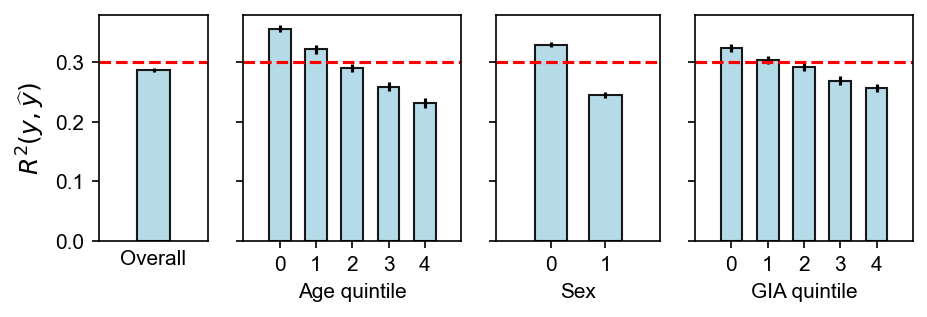

In [7]:
fig, axes = plt.subplots(
    figsize=(7, 2),
    dpi=150,
    ncols=4,
    sharey=True,
    gridspec_kw={"width_ratios": [1, 2, 1.5, 2]},
)

dict_cov_label = {
    "marginal": "Overall",
    "AGE_q": "Age quintile",
    "GIA_q": "GIA quintile",
    "SEX_q": "Sex",
}

for i, cov in enumerate(
    [
        "marginal",
        "AGE_q",
        "SEX_q",
        "GIA_q",
    ]
):
    df_tmp = dict_df_plot["none"].query("(n==5000)")
    r2 = df_tmp[df_tmp["col"].str.startswith(cov)].groupby("col").mean()["r2"].values
    r2_se = df_tmp[df_tmp["col"].str.startswith(cov)].groupby("col").sem()["r2"].values
    axes[i].bar(
        x=np.arange(len(r2)),
        height=r2,
        yerr=r2_se * 2,
        edgecolor="k",
        linewidth=1,
        alpha=0.9,
        color="lightblue",
        width=0.6,
    )
    axes[i].set_xlim(-1, len(r2))

    if cov == "marginal":
        axes[i].set_xticks([])
    else:
        axes[i].set_xticks(np.arange(len(r2)))
    axes[i].set_xlabel(dict_cov_label[cov])
    axes[i].axhline(y=0.3, ls="--", color="red")
axes[0].set_yticks([0, 0.1, 0.2, 0.3])
axes[0].set_ylabel("$R^2 (y, \widehat{y})$", fontsize=12)
plt.savefig("results/r2.pdf", bbox_inches="tight")

# Main figure

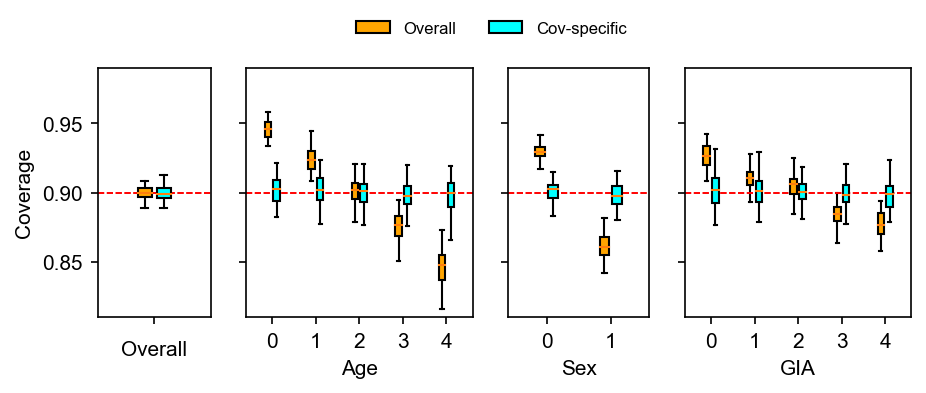

In [8]:
# overall calibration only

df_plot = dict_df_plot["none"].query("n == 5000").drop(columns=["n"])
df_plot["group"] = df_plot["col"].apply(lambda x: x.split("_")[0])
df_plot["group"] = df_plot["group"].replace(
    {"marginal": "Overall", "SEX": "Sex", "AGE": "Age"}
)
df_plot["subgroup"] = df_plot["col"].apply(
    lambda x: x.rsplit("_", 1)[1] if "_" in x else ""
)


fig, axes = plt.subplots(
    figsize=(7, 2.2),
    ncols=4,
    sharey=True,
    gridspec_kw={"width_ratios": np.array([1, 5, 2, 5]) + 3},
    dpi=150,
)


group_boxplot(
    df_plot,
    val_col="coverage",
    group_list=["Overall", "Age", "Sex", "GIA"],
    pos_offset=-0.1,
    axes=axes,
    color="orange",
)

# Covariate-specific calibration
df_plot = dict_df_plot["all"].query("n == 5000").drop(columns=["n"])
df_plot["group"] = df_plot["col"].apply(lambda x: x.split("_")[0])
df_plot["group"] = df_plot["group"].replace(
    {"marginal": "Overall", "SEX": "Sex", "AGE": "Age"}
)
df_plot["subgroup"] = df_plot["col"].apply(
    lambda x: x.rsplit("_", 1)[1] if "_" in x else ""
)

group_boxplot(
    df_plot,
    val_col="coverage",
    group_list=["Overall", "Age", "Sex", "GIA"],
    pos_offset=0.1,
    axes=axes,
    color="cyan",
)

axes[0].set_ylim(0.81, 0.99)


legend_elements = [
    Patch(facecolor="orange", edgecolor="k", label="Overall"),
    Patch(facecolor="cyan", edgecolor="k", label="Cov-specific"),
]

# Create the figure
fig.legend(
    handles=legend_elements,
    loc="center",
    ncol=2,
    bbox_to_anchor=(0.5, 1.0),
    fontsize=8,
    frameon=False,
)

plt.savefig("results/main_coverage.pdf", bbox_inches="tight")

In [9]:
# effect of number of dummy variables to the calibration

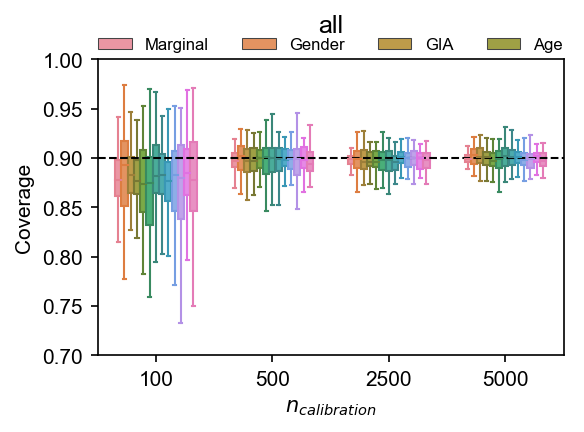

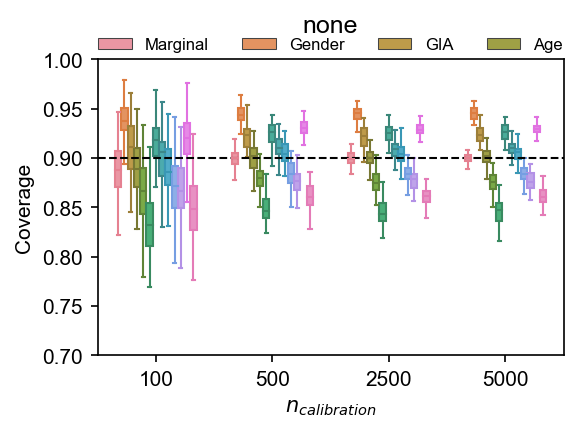

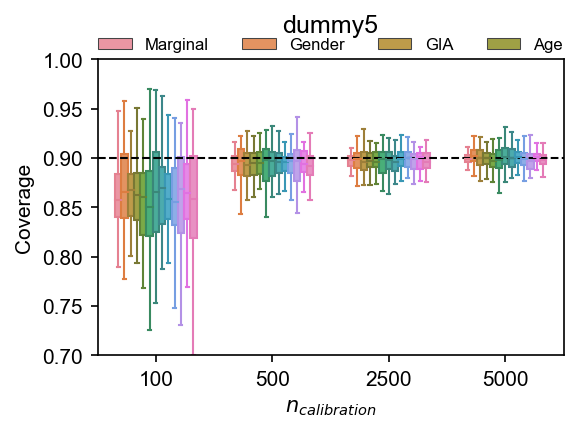

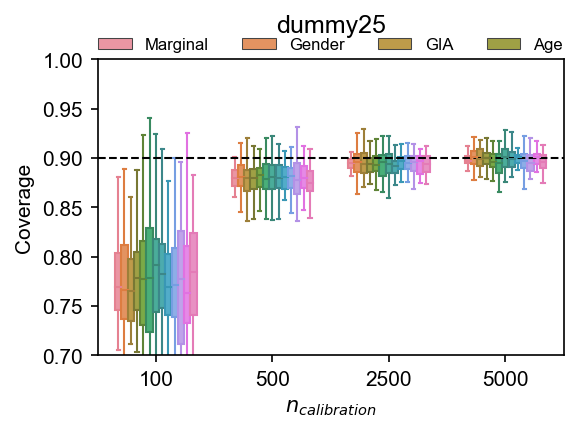

In [10]:
for adjust in dict_df_plot:
    df_plot = dict_df_plot[adjust]

    fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

    sns.boxplot(
        x="n",
        y="coverage",
        hue="col",
        width=0.7,
        linewidth=1.0,
        fliersize=0,
        data=df_plot,
        ax=ax,
    )

    ax.axhline(y=0.9, color="black", lw=1.0, ls="--")
    ax.set_xlabel("$n_{calibration}$")
    ax.set_ylabel("Coverage")

    lighten_boxplot(ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles,
        labels=[
            "Marginal",
            "Gender",
            "GIA",
            "Age",
        ],
        title=None,
        ncol=4,
        loc="center",
        bbox_to_anchor=(0.5, 1.05),
        fontsize=8,
        frameon=False,
    )
    ax.set_ylim(0.7, 1.0)
    ax.set_title(adjust, y=1.05)
    plt.tight_layout()

    plt.savefig(f"results/coverage_{adjust}.pdf", bbox_inches="tight")